In [1]:
#This model is based on the paper of Liu et al.


import pandas as pd
import requests
import os
import numpy as np
!pip install python-igraph
import networkx as nx
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, precision_recall_curve, average_precision_score, make_scorer
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import igraph as ig
import sys
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler
from pu_learning import spies
from sklearn.base import clone
import time
import optuna




In [2]:
data = pd.read_csv("creditcard.csv") 


In [3]:
X = data.drop(columns=["Class"])
y = data["Class"]


#Train/test split
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# Train/validation split withing the trainingset
X_train, X_val, y_train_true, y_val_true = train_test_split(
    X_train_full, y_train_full, test_size=0.2, stratify=y_train_full, random_state=42
)



In [4]:
print(X_test)

            Time        V1        V2        V3        V4        V5        V6  \
186882  127294.0 -2.537331  1.890864 -0.840555 -1.102759 -2.105725  0.367811   
165754  117632.0 -0.250839  1.104108  0.206089  0.417324  1.204079 -0.350694   
235285  148330.0  0.568980 -2.520416 -1.114138  1.670652 -1.128945  0.398822   
101271   67778.0  1.328892  0.226908 -0.308968  0.381772  0.238490 -0.282946   
5832      6308.0  1.124863 -0.165691  1.337053  1.030033 -0.891116  0.202926   
...          ...       ...       ...       ...       ...       ...       ...   
64725    51279.0 -1.808185  1.328808 -0.991449 -2.473986  2.185095  3.496806   
16688    28048.0 -0.442905  0.716727  1.256775  0.860048  1.210872  1.066390   
183868  125990.0  2.092418 -0.931315 -1.553089 -1.131369 -0.197801 -0.373117   
45011    42168.0  1.293234  0.097565 -0.209304  0.329036  0.034958 -0.145507   
150527   93609.0  2.214016 -0.584030 -1.238673 -0.702993 -0.184492 -0.646248   

              V7        V8        V9  .

In [5]:
def maak_pu_setting_van_echte_labels(y_true, label_ratio, random_state=42):
   
    np.random.seed(random_state)

    # Take only real positives
    positieve_indexen = np.where(y_true == 1)[0]
    n_gelabeld = int(label_ratio * len(positieve_indexen))
    gelabelde_indexen = np.random.choice(positieve_indexen, size=n_gelabeld, replace=False)

    y_pu = np.zeros_like(y_true)
    y_pu[gelabelde_indexen] = 1

    return y_pu, y_true, gelabelde_indexen


y_train_pu, y_train_true, gelabelde_indexen = maak_pu_setting_van_echte_labels(y_train_true, label_ratio=0.2)


In [6]:
!pip install optuna

In [7]:
def objective(trial):
    params = {
        "objective": "binary:logistic",
        "eval_metric": "logloss",
        "use_label_encoder": False,
        "tree_method": "hist",
        "n_estimators": trial.suggest_int("n_estimators", 50, 600),
        "max_depth": trial.suggest_int("max_depth", 3, 30),
        "learning_rate": trial.suggest_float("learning_rate", 0.0004, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "gamma": trial.suggest_float("gamma", 0.0, 5.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 10.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 10.0),
        "scale_pos_weight": trial.suggest_float("scale_pos_weight", 1.0, 20.0)
    }

    model = XGBClassifier(**params)
    
    # Train on PU-labels
    model.fit(X_train, y_train_pu)
    
    # Predict and evaluate on true labels
    y_val_pred = model.predict(X_val)
    score = f1_score(y_val_true, y_val_pred)

    return score


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30, timeout=1200)

print("Beste hyperparameters:", study.best_params)

# use of the best model
best_params = study.best_params
best_params.update({
    "objective": "binary:logistic",
    "eval_metric": "logloss",
    "use_label_encoder": False,
    "tree_method": "hist"
})
xgb_best = XGBClassifier(**best_params)

[I 2025-05-13 21:11:32,929] A new study created in memory with name: no-name-65924623-207e-47f0-a684-114dfd9d67cb
[I 2025-05-13 21:11:37,745] Trial 0 finished with value: 0.2716049382716049 and parameters: {'n_estimators': 439, 'max_depth': 3, 'learning_rate': 0.04426202834347583, 'subsample': 0.7744778556049362, 'colsample_bytree': 0.9648617972140273, 'gamma': 0.894353464961245, 'reg_alpha': 0.10891067322944536, 'reg_lambda': 1.0603765779170626, 'scale_pos_weight': 17.740956751647687}. Best is trial 0 with value: 0.2716049382716049.
[I 2025-05-13 21:11:41,074] Trial 1 finished with value: 0.372093023255814 and parameters: {'n_estimators': 159, 'max_depth': 7, 'learning_rate': 0.2344778608060035, 'subsample': 0.63831816646796, 'colsample_bytree': 0.8428411299685217, 'gamma': 0.32892868633301486, 'reg_alpha': 8.70986305190525, 'reg_lambda': 7.894829669847353, 'scale_pos_weight': 15.882782777503522}. Best is trial 1 with value: 0.372093023255814.
[I 2025-05-13 21:11:44,339] Trial 2 finis

[I 2025-05-13 21:12:58,195] Trial 20 finished with value: 0.5510204081632654 and parameters: {'n_estimators': 204, 'max_depth': 3, 'learning_rate': 0.08931235760938568, 'subsample': 0.8169482917305003, 'colsample_bytree': 0.87382422581479, 'gamma': 2.9457490262233996, 'reg_alpha': 6.244357581780246, 'reg_lambda': 7.367138296462917, 'scale_pos_weight': 12.599466523455023}. Best is trial 12 with value: 0.7333333333333333.
[I 2025-05-13 21:13:02,201] Trial 21 finished with value: 0.7192982456140351 and parameters: {'n_estimators': 374, 'max_depth': 4, 'learning_rate': 0.01608122613808523, 'subsample': 0.9221788923230183, 'colsample_bytree': 0.9136764601594917, 'gamma': 2.207623384733501, 'reg_alpha': 4.429220342227637, 'reg_lambda': 4.806851143227526, 'scale_pos_weight': 15.92599082275586}. Best is trial 12 with value: 0.7333333333333333.
[I 2025-05-13 21:13:05,775] Trial 22 finished with value: 0.5052631578947369 and parameters: {'n_estimators': 310, 'max_depth': 4, 'learning_rate': 0.02

Beste hyperparameters: {'n_estimators': 494, 'max_depth': 3, 'learning_rate': 0.010504447308353851, 'subsample': 0.8338640173166506, 'colsample_bytree': 0.8434149621082773, 'gamma': 1.5580625536799122, 'reg_alpha': 3.177731215243673, 'reg_lambda': 9.977937415738426, 'scale_pos_weight': 17.619151256521704}


In [112]:
# best parameters last run (13/05): Beste hyperparameters: {'n_estimators': 494, 'max_depth': 3, 'learning_rate': 0.010504447308353851, 'subsample': 0.8338640173166506, 'colsample_bytree': 0.8434149621082773, 'gamma': 1.5580625536799122, 'reg_alpha': 3.177731215243673, 'reg_lambda': 9.977937415738426, 'scale_pos_weight': 17.619151256521704}
#DEZE ZIJN HIERONDER NOG NIET INGEGEVEN


#xgb_best = XGBClassifier(
#    n_estimators=519,
#    max_depth=7,
#    learning_rate=0.1269773573167832,
#    subsample=0.7126546507693278,
#    colsample_bytree=0.9221269927327422,
#    gamma=0.16427360761648913,
#    reg_alpha=0.10626085090715165,
#    reg_lambda=3.330353762196551,
#    scale_pos_weight=18.74094878654416,
#    tree_method='hist',
#    use_label_encoder=False,
#    eval_metric='logloss',
#    random_state=42
#)



In [11]:
# S-EM IMPLEMENTATION ---
def spy_em(X, y, base_model, spy_ratio=0.2, spy_tolerance=0.05, max_iter=20, tol=1e-4, random_state=42):
    np.random.seed(random_state)
    positives = X[y == 1]   #SPIES PHASE: we assign the instances where y == 1 the label positives, and the rest are treated as unlabeled
    unlabeled = X[y == 0]

    spy_mask = np.random.rand(len(positives)) < spy_ratio   # now we select spies from the positives
    spies = positives[spy_mask]   #These are the spies
    non_spy_positives = positives[~spy_mask]   # These are the positives that are not the spies 

    MS = np.vstack([unlabeled, spies]) # this is the Mixed unlabeled set incl. spies
    MS_labels = np.concatenate([np.zeros(len(unlabeled)), np.ones(len(spies))])   # Spies get a temporary label
    MSP = np.vstack([MS, non_spy_positives])     ## add to non-Spy positives to the mixed unlabeled set
    MSP_y = np.concatenate([MS_labels, np.ones(len(non_spy_positives))])

    model = clone(base_model)
    model.fit(MSP, MSP_y) #We train an initial model on the combined dataset MSP (which includes the spies, non-spy positives, and unlabeled instances)
    probs = model.predict_proba(MS)[:, 1] #we then predict for MS (spies + unlabeled) the probability that each instance is positive
    spy_labels = MS_labels == 1

    threshold = 0.001   #You set a threshold such that at most a small percentage (e.g., 5%) of the spies fall below that threshold.


    while (probs[spy_labels] <= threshold).mean() <= spy_tolerance and threshold < 1.0:
        threshold += 0.001       #What remains (the truly unlabeled instances with low probability) is then considered as reliable negative examples.

    reliable_N = MS[(MS_labels == 0) & (probs <= threshold)]     #All instances in the original unlabeled set whose predicted probability of being positive falls below the threshold are included as reliable negative examples
    current_model = clone(base_model)
    prev_loss = None

    for iteration in range(max_iter):  #EM phase: You train a new model on the combination of the reliable negatives (label 0) and positives (label 1)
        start_time = time.time()
        NP = np.vstack([reliable_N, positives])
        labels = np.concatenate([np.zeros(len(reliable_N)), np.ones(len(positives))])

        current_model.fit(
            NP, labels,
            eval_set=[(NP, labels)],
            early_stopping_rounds=10,
            verbose=False
        )

        probs = current_model.predict_proba(MS)[:, 1]    #We now evaluate again on the mixed set (MS), which includes spies and unlabeled instances, to select new reliable negatives.
        new_reliable_N = MS[(MS_labels == 0) & (probs <= threshold)]   #we have new reliable negatives

        loss = np.mean((reliable_N - new_reliable_N)**2) if len(reliable_N) == len(new_reliable_N) else np.inf  # Convergentiecriterium
        print(f"Iteratie {iteration + 1} duurde {time.time() - start_time:.2f}s")
        if prev_loss is not None and abs(prev_loss - loss) < tol:
            print(f"Geconvergeerd na {iteration+1} iteraties.")
            break
        reliable_N = new_reliable_N
        prev_loss = loss

    return current_model, threshold, reliable_N

In [12]:

# PU-training 
final_model, best_thresh, reliable_negatives = spy_em(X_train, y_train_pu, xgb_best) 
# predictions
y_prob = final_model.predict_proba(X_test)[:, 1]
prec, rec, thresholds = precision_recall_curve(y_test, y_prob)
f1_scores = 2 * (prec * rec) / (prec + rec + 1e-8)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
y_pred = (y_prob >=best_threshold).astype(int)

# Evaluation
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)
pr_auc = average_precision_score(y_test, y_prob)

print("Model evaluatie (S-EM): met threshold", best_threshold)
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print(f"PR AUC: {pr_auc:.4f}")

/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Iteratie 1 duurde 8.09s
Iteratie 2 duurde 7.29s
Iteratie 3 duurde 7.18s
Iteratie 4 duurde 7.23s
Iteratie 5 duurde 7.21s
Iteratie 6 duurde 7.03s
Iteratie 7 duurde 6.98s
Iteratie 8 duurde 7.53s
Geconvergeerd na 8 iteraties.
Model evaluatie (S-EM): met threshold 0.7751228
Accuracy: 0.9994
Precision: 0.8780
Recall: 0.7297
F1-score: 0.7970
ROC AUC: 0.9505
PR AUC: 0.6721


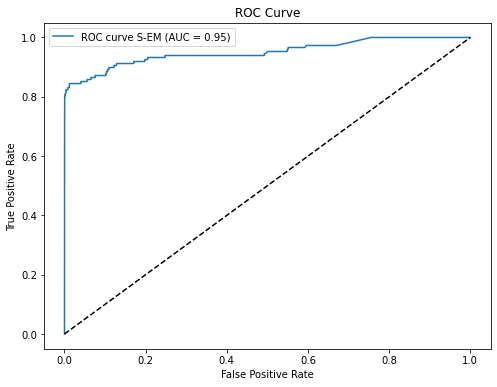

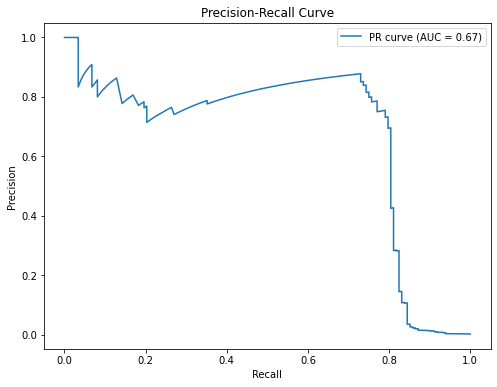

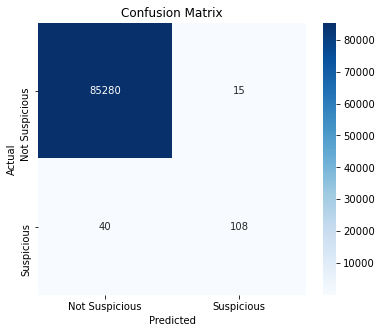

In [13]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve S-EM (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# Precision-Recall Curve 
precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(recall_vals, precision_vals, label=f'PR curve (AUC = {pr_auc:.2f})')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()

# Confusion Matrix 
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=['Not Suspicious', 'Suspicious'], yticklabels=['Not Suspicious', 'Suspicious'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [14]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix

fpr_pu, tpr_pu, _ = roc_curve(y_test, y_prob)
auc_pu = roc_auc_score(y_test, y_prob)

np.savez("roc_S-EM(FRAUDE).npz",
         fpr=fpr_pu,
         tpr=tpr_pu,
         auc=auc_pu,
         labels=y_test,
         scores=y_prob)


In [15]:
np.save("preds_S-EM(FRAUDE).npy", y_pred)